In [1]:
import tensorflow as tf
import os
import cv2
import shutil
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, ZeroPadding2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
base_path = '/kaggle/input/pkl-murni'
data_dir = os.path.join(base_path, 'to_train')

dataset_path = os.path.join(data_dir, 'preprocessed')
train_path = os.path.join(data_dir, 'training')
valid_path = os.path.join(data_dir, 'validation')
testing_path = os.path.join(data_dir, 'testing')

In [3]:
img_height, img_width = 224, 224
validation_split=0.2

In [4]:
train_gen = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset='training',
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
)

Found 258 files belonging to 19 classes.
Using 207 files for training.


In [5]:
validate_gen = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    seed=123,
    subset='validation',
    label_mode='categorical',
    image_size=(img_height, img_width),
)

Found 258 files belonging to 19 classes.
Using 51 files for validation.


In [6]:
def residual_block(x, filters, stride=1, use_projection=False):
    identity = x

    # First convolution layer in the block
    x = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer in the block
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Third convolution layer in the block
    x = Conv2D(filters * 4, kernel_size=(1, 1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    # Projection shortcut for identity
    if use_projection:
        identity = Conv2D(filters * 4, kernel_size=(1, 1), strides=stride, padding='valid')(identity)
        identity = BatchNormalization()(identity)

    # Adding the identity (skip connection) to the output
    x = Add()([x, identity])
    x = ReLU()(x)

    return x

In [7]:
def build_resnet101(dropout, input_shape=(224, 224, 3), num_classes=len(train_gen.class_names)):
    input_tensor = Input(shape=input_shape)

    x = ZeroPadding2D((3, 3))(input_tensor)
    
    # Stage 1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='same')(x)

    x = residual_block(x, filters=64, stride=1, use_projection=True)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

# Stage 2
    x = residual_block(x, filters=128, stride=2, use_projection=True)
    for _ in range(3):
        x = residual_block(x, filters=128)

# Stage 3
    x = residual_block(x, filters=256, stride=2, use_projection=True)
    for _ in range(22):
        x = residual_block(x, filters=256)

# Stage 4
    x = residual_block(x, filters=512, stride=2, use_projection=True)
    for _ in range(2):
        x = residual_block(x, filters=512)

    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Fully connected layer
    if dropout != 0:
        x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Creating the model
    model = Model(inputs=input_tensor, outputs=x, name='resnet101')

    return model

In [8]:
def build_resnet50(dropout, input_shape=(224, 224, 3), num_classes=len(train_gen.class_names)):
    input_tensor = Input(shape=input_shape)

    x = ZeroPadding2D((3, 3))(input_tensor)

    # Stage 1
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = residual_block(x, filters=64, stride=1, use_projection=True)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

# Stage 2
    x = residual_block(x, filters=128, stride=2, use_projection=True)
    for _ in range(3):
        x = residual_block(x, filters=128)

# Stage 3
    x = residual_block(x, filters=256, stride=2, use_projection=True)
    for _ in range(5):
        x = residual_block(x, filters=256)

# Stage 4
    x = residual_block(x, filters=512, stride=2, use_projection=True)
    for _ in range(2):
        x = residual_block(x, filters=512)

    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Fully connected layer
    if dropout != 0:
        x = tf.keras.layers.Dropout(dropout)(x)
        
    x = tf.keras.layers.Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Creating the model
    model = Model(inputs=input_tensor, outputs=x, name='resnet50')

    return model

In [9]:
def print_history(history, epoch):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy')
    plt.axis([0, epoch, 0, max(history.history['val_accuracy'])])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.axis([0, epoch, 0, max(history.history['val_loss'])])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training loss', 'validation loss'], loc='upper left')
    plt.show()

In [8]:
output_dir = '/kaggle/working/'
model_resnet101 = os.path.join(output_dir, 'resnet101_180.h5')
model_resnet50 = os.path.join(output_dir, 'resnet50_180.h5')

save_model_101 = tf.keras.callbacks.ModelCheckpoint(
   model_resnet101,
   monitor='val_accuracy', 
   save_best_only=True, 
   mode='max', 
   verbose=1
)
save_model_50 = tf.keras.callbacks.ModelCheckpoint(
   model_resnet50,
   monitor='val_accuracy', 
   save_best_only=True, 
   mode='max', 
   verbose=1
)

In [11]:
def build_101(batch_size, epoch, learning_rate, dropout):
    resnet101 = build_resnet101(dropout=dropout)
    resnet101.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    history = resnet101.fit(
      train_gen,
      epochs=epoch,
      validation_data=validate_gen,
      batch_size=batch_size,
      callbacks=[save_model_101]
    )
    print_history(history, epoch)
    return resnet101

In [12]:
def build_50(batch_size, epoch, learning_rate, dropout):
    model = build_resnet50(dropout=dropout)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
      train_gen,
      epochs=epoch,
      validation_data=validate_gen,
      batch_size=batch_size,
      callbacks=[save_model_50]
    )
    print_history(history, epoch)
    return model

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 3.9214 - accuracy: 0.0966
Epoch 1: val_accuracy improved from -inf to 0.07843, saving model to /kaggle/working/resnet101_180.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 92s 1s/step - loss: 3.9214 - accuracy: 0.0966 - val_loss: 3.9005 - val_accuracy: 0.0784
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 3.8965 - accuracy: 0.1014
Epoch 2: val_accuracy improved from 0.07843 to 0.11765, saving model to /kaggle/working/resnet101_180.h5
7/7 [==============================] - 5s 685ms/step - loss: 3.8965 - accuracy: 0.1014 - val_loss: 2.8809 - val_accuracy: 0.1176
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 3.8664 - accuracy: 0.0966
Epoch 3: val_accuracy did not improve from 0.11765
7/7 [==============================] - 2s 301ms/step - loss: 3.8664 - accuracy: 0.0966 - val_loss: 2.9108 - val_accuracy: 0.0588
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 3.8387 - accuracy: 0.1159
Epoch 4: val_accuracy did not improve from 0.11765
7/7 [==============================] - 2s 299ms/step - loss: 3.8387 - accuracy: 0.1159 - val_loss: 2.9430 - val_accuracy: 0.0000e

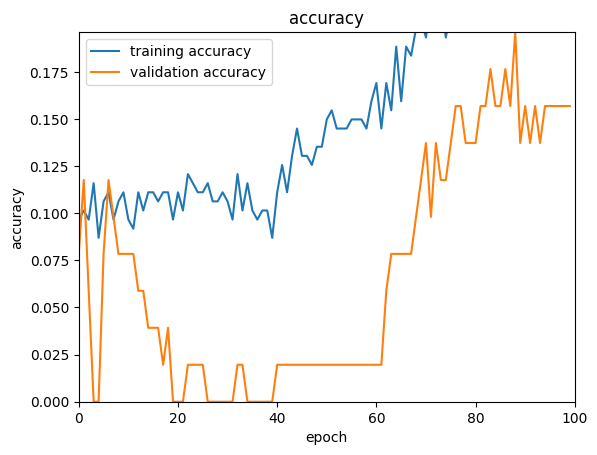

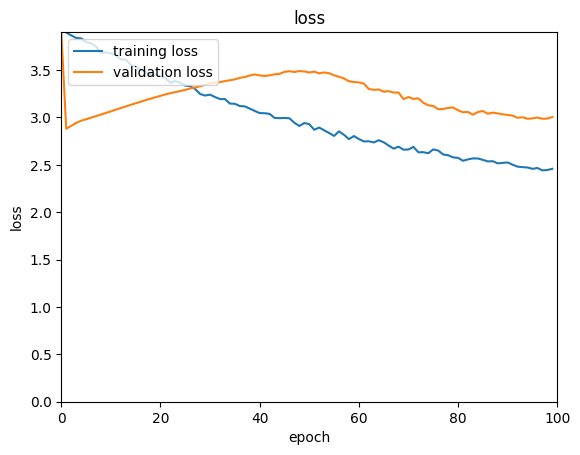

In [13]:
model_101 = build_101(8, 100, 0.000001, 0)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 4.1403 - accuracy: 0.0338
Epoch 1: val_accuracy improved from -inf to 0.13725, saving model to /kaggle/working/resnet50_180.h5
7/7 [==============================] - 43s 558ms/step - loss: 4.1403 - accuracy: 0.0338 - val_loss: 3.2357 - val_accuracy: 0.1373
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 4.1083 - accuracy: 0.0290
Epoch 2: val_accuracy did not improve from 0.13725
7/7 [==============================] - 2s 189ms/step - loss: 4.1083 - accuracy: 0.0290 - val_loss: 2.8852 - val_accuracy: 0.1373
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 4.0313 - accuracy: 0.0242
Epoch 3: val_accuracy improved from 0.13725 to 0.15686, saving model to /kaggle/working/resnet50_180.h5
7/7 [==============================] - 3s 381ms/step - loss: 4.0313 - accuracy: 0.0242 - val_loss: 2.8403 - val_accuracy: 0.1569
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 4.0405 - a

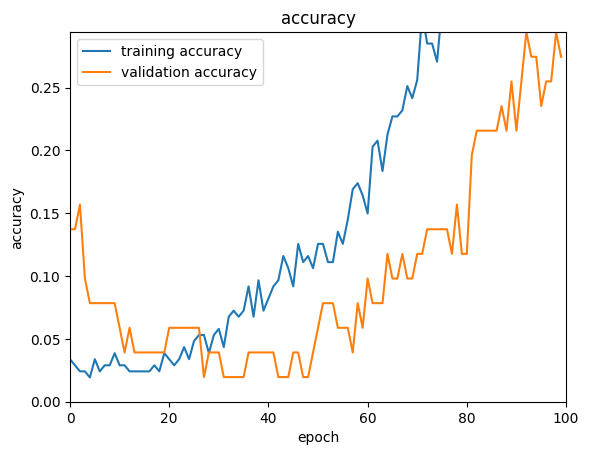

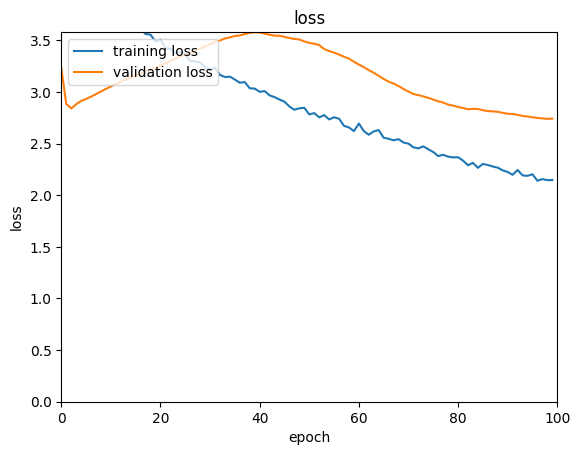

In [14]:
model_50 = build_50(8, 100, 0.000001, 0)

In [9]:
resnet101 = keras.models.load_model(model_resnet101)
resnet50 = keras.models.load_model(model_resnet50)

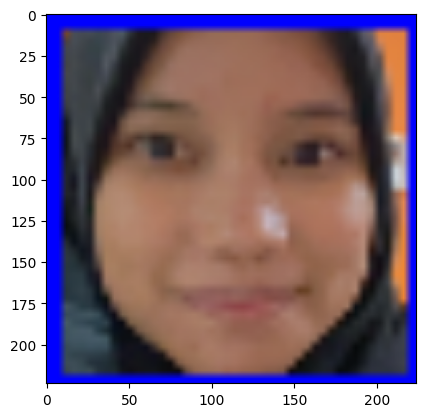

1/1 [==============================] - 1s 1s/step
Nama File:  2017051051_face_2017051051_20221227_Pulang_33.png
Prediksi 101:  unknown
Probabilitas 101:  0.13617101311683655
Prediksi 50:  unknown
Probabilitas 50:  0.1576356738805771




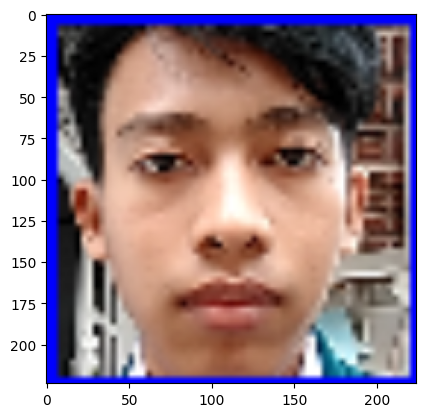

1/1 [==============================] - 0s 23ms/step
Nama File:  2017051026_face_2017051026_20221228_Pulang_97.png
Prediksi 101:  unknown
Probabilitas 101:  0.2292008250951767
Prediksi 50:  unknown
Probabilitas 50:  0.25307077169418335




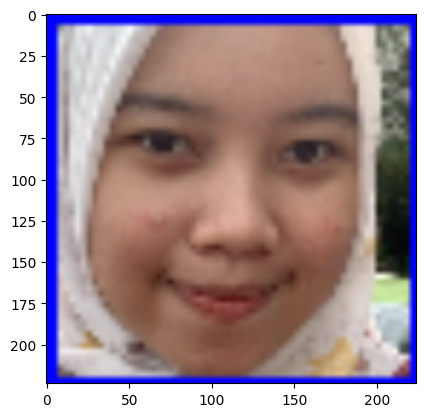

1/1 [==============================] - 0s 23ms/step
Nama File:  2057051006_face_2057051006_20221230_Masuk_97.png
Prediksi 101:  unknown
Probabilitas 101:  0.14531850814819336
Prediksi 50:  unknown
Probabilitas 50:  0.14467816054821014




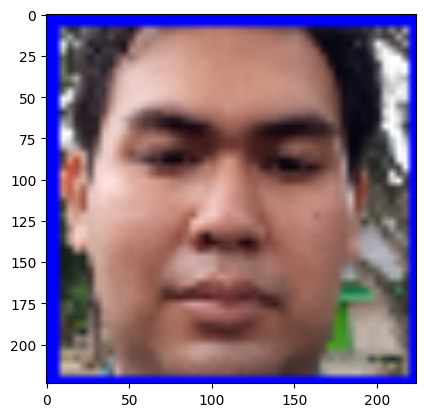

1/1 [==============================] - 0s 22ms/step
Nama File:  2057051016_face_2057051016_20221227_Tidak Aktif_7.png
Prediksi 101:  unknown
Probabilitas 101:  0.12385720759630203
Prediksi 50:  unknown
Probabilitas 50:  0.12562474608421326




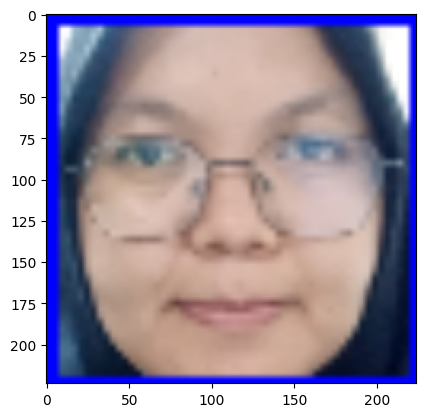

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051016_face_2017051016_20221227_Pulang_37.png
Prediksi 101:  unknown
Probabilitas 101:  0.16948039829730988
Prediksi 50:  unknown
Probabilitas 50:  0.1410473734140396




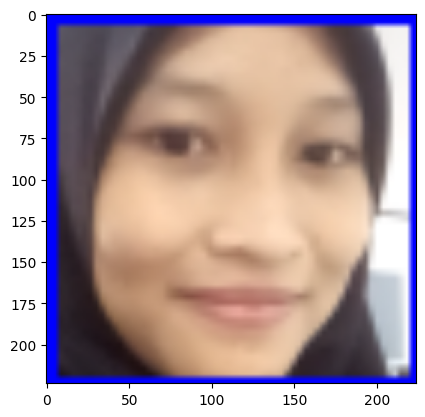

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051013_face_2017051013_20221229_Masuk_64.png
Prediksi 101:  unknown
Probabilitas 101:  0.1657453179359436
Prediksi 50:  unknown
Probabilitas 50:  0.18636491894721985




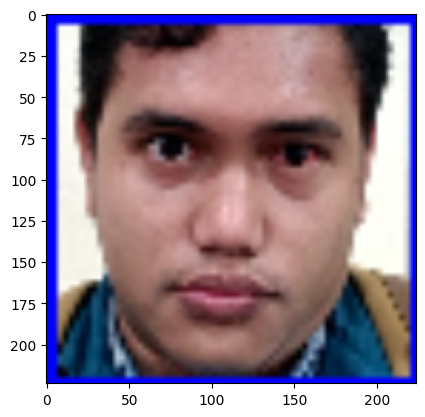

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051033_face_2017051033_20221231_Datang Terlambat_81.png
Prediksi 101:  1917051041
Probabilitas 101:  0.46292805671691895
Prediksi 50:  1917051041
Probabilitas 50:  0.304367333650589




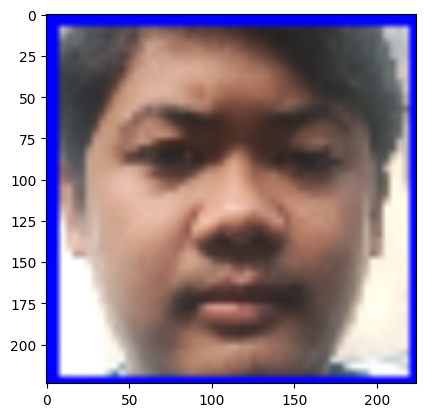

1/1 [==============================] - 0s 22ms/step
Nama File:  2057051003_face_2057051003_20230102_Masuk_52.png
Prediksi 101:  unknown
Probabilitas 101:  0.11542762815952301
Prediksi 50:  unknown
Probabilitas 50:  0.16391906142234802




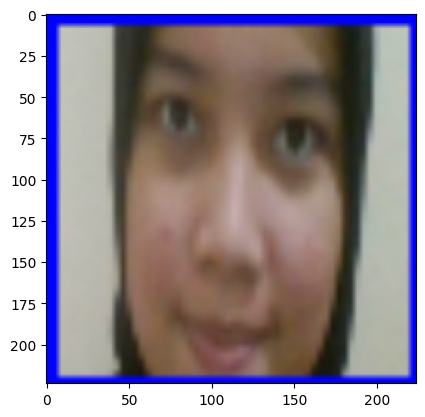

1/1 [==============================] - 0s 21ms/step
Nama File:  2057051006_face_2057051006_20221228_Pulang_47.png
Prediksi 101:  unknown
Probabilitas 101:  0.1447628140449524
Prediksi 50:  unknown
Probabilitas 50:  0.1668432503938675




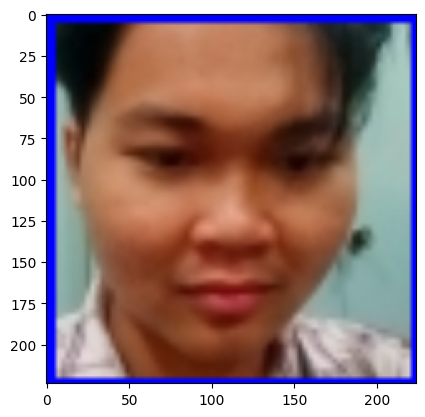

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051004_face_2017051004_20221228_Masuk_82.png
Prediksi 101:  unknown
Probabilitas 101:  0.13373953104019165
Prediksi 50:  unknown
Probabilitas 50:  0.1228506788611412




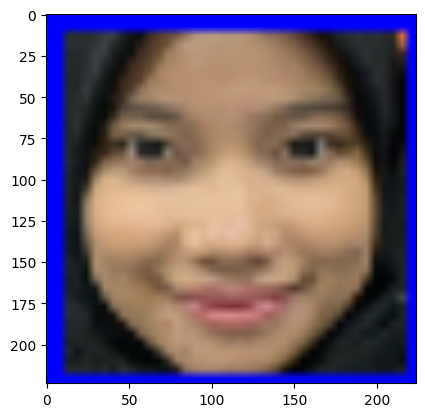

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051051_face_2017051051_20221228_Masuk_52.png
Prediksi 101:  unknown
Probabilitas 101:  0.10970314592123032
Prediksi 50:  unknown
Probabilitas 50:  0.19717341661453247




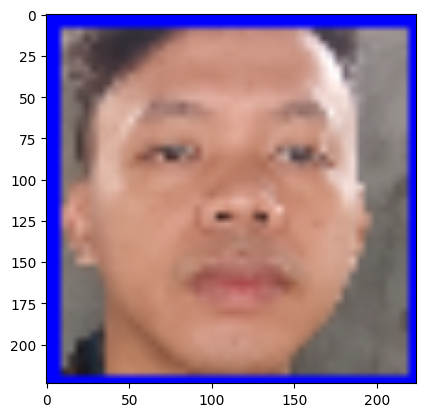

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051020_face_2017051020_20221230_Masuk_97.png
Prediksi 101:  unknown
Probabilitas 101:  0.17373424768447876
Prediksi 50:  unknown
Probabilitas 50:  0.1420607715845108




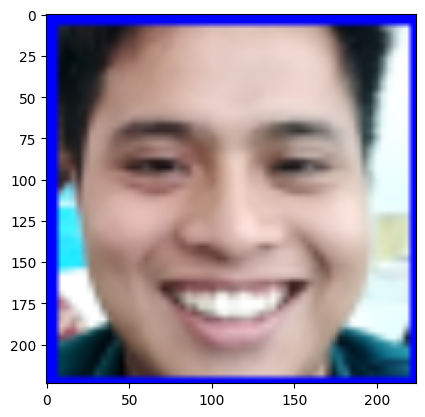

1/1 [==============================] - 0s 25ms/step
Nama File:  1917051033_face_1917051033_20221230_Pulang Cepat_66.png
Prediksi 101:  unknown
Probabilitas 101:  0.29422610998153687
Prediksi 50:  2017051033
Probabilitas 50:  0.32285094261169434




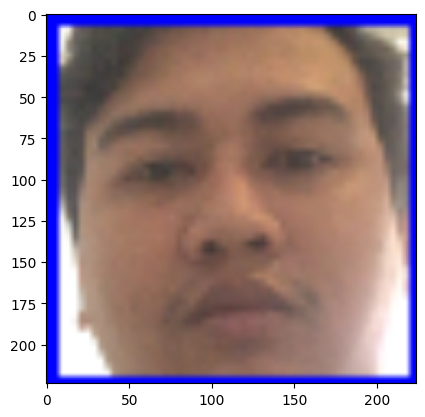

1/1 [==============================] - 0s 22ms/step
Nama File:  1917051029_face_1917051029_20221226_Datang Terlambat_50.png
Prediksi 101:  unknown
Probabilitas 101:  0.14460895955562592
Prediksi 50:  unknown
Probabilitas 50:  0.12814132869243622




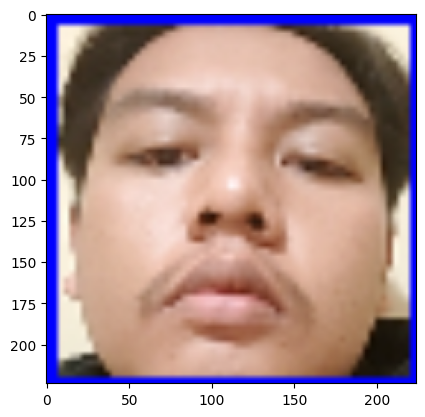

1/1 [==============================] - 0s 21ms/step
Nama File:  1917051041_face_1917051041_20221228_Datang Terlambat_55.png
Prediksi 101:  unknown
Probabilitas 101:  0.1284974068403244
Prediksi 50:  unknown
Probabilitas 50:  0.13789589703083038




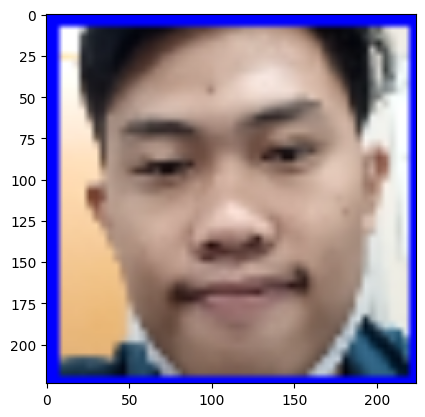

1/1 [==============================] - 0s 22ms/step
Nama File:  2017051044_face_2017051044_20221230_Masuk_81.png
Prediksi 101:  unknown
Probabilitas 101:  0.22825101017951965
Prediksi 50:  unknown
Probabilitas 50:  0.1627054065465927




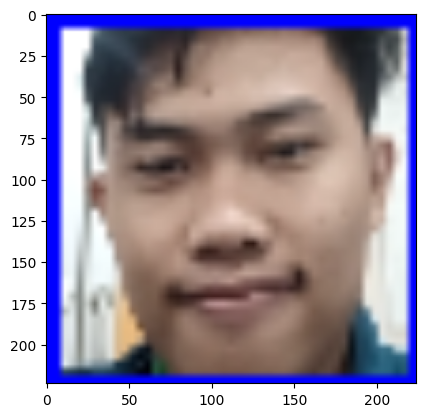

1/1 [==============================] - 0s 22ms/step
Nama File:  2017051044_face_2017051044_20221227_Masuk_8.png
Prediksi 101:  unknown
Probabilitas 101:  0.28800612688064575
Prediksi 50:  unknown
Probabilitas 50:  0.13233527541160583




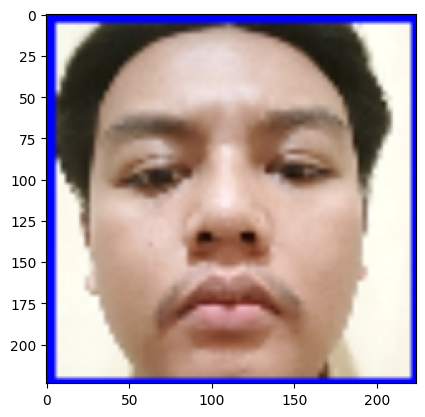

1/1 [==============================] - 0s 21ms/step
Nama File:  1917051041_face_1917051041_20221230_Pulang_95.png
Prediksi 101:  1917051041
Probabilitas 101:  0.623001754283905
Prediksi 50:  1917051041
Probabilitas 50:  0.49587392807006836




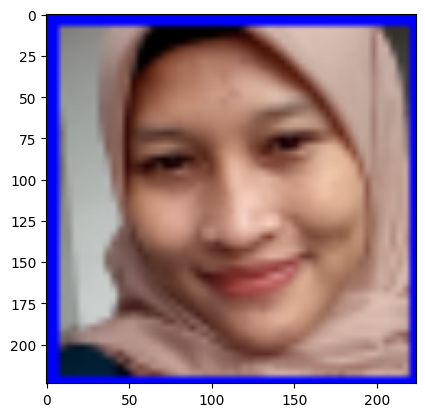

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051013_face_2017051013_20221228_Masuk_79.png
Prediksi 101:  unknown
Probabilitas 101:  0.13851198554039001
Prediksi 50:  unknown
Probabilitas 50:  0.11590355634689331




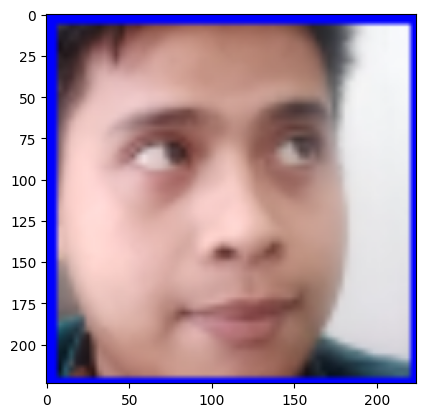

1/1 [==============================] - 0s 21ms/step
Nama File:  1917051033_face_1917051033_20221228_Pulang Cepat_61.png
Prediksi 101:  unknown
Probabilitas 101:  0.13737739622592926
Prediksi 50:  unknown
Probabilitas 50:  0.16128946840763092




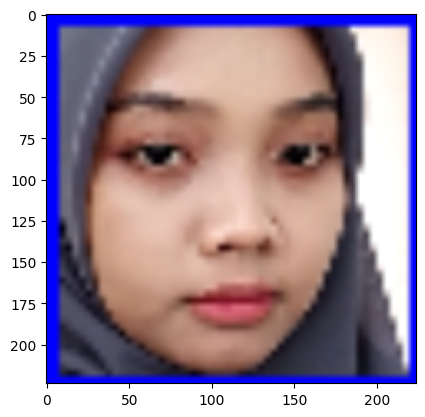

1/1 [==============================] - 0s 22ms/step
Nama File:  2017051079_face_2017051079_20221228_Pulang_62.png
Prediksi 101:  unknown
Probabilitas 101:  0.12861719727516174
Prediksi 50:  unknown
Probabilitas 50:  0.12263596057891846




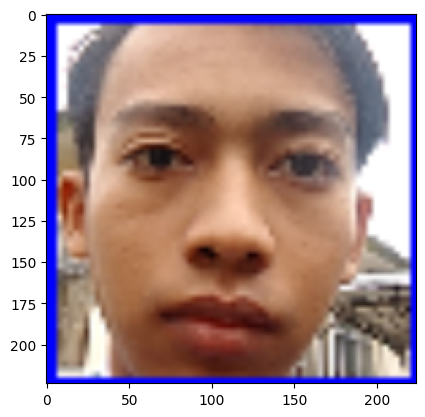

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051026_face_2017051026_20221227_Masuk_77.png
Prediksi 101:  unknown
Probabilitas 101:  0.18805564939975739
Prediksi 50:  unknown
Probabilitas 50:  0.1750543862581253




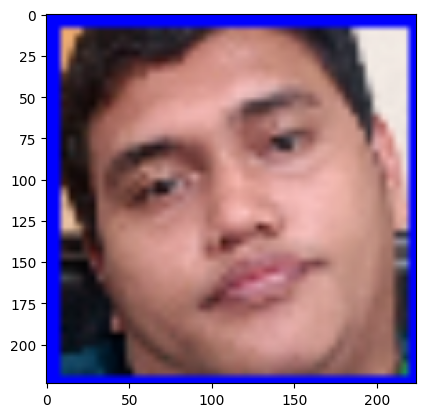

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051033_face_2017051033_20221229_Pulang Cepat_16.png
Prediksi 101:  unknown
Probabilitas 101:  0.12008479982614517
Prediksi 50:  unknown
Probabilitas 50:  0.17667929828166962




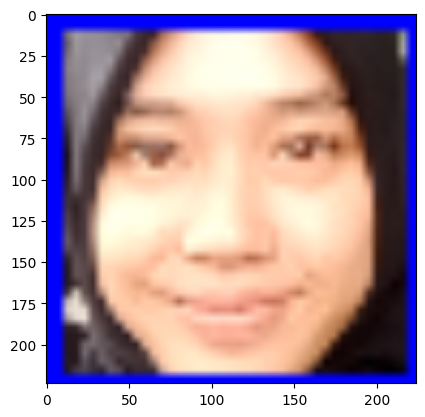

1/1 [==============================] - 0s 20ms/step
Nama File:  2017051031_face_2017051031_20230102_Masuk_12.png
Prediksi 101:  unknown
Probabilitas 101:  0.11344292759895325
Prediksi 50:  unknown
Probabilitas 50:  0.1848202645778656




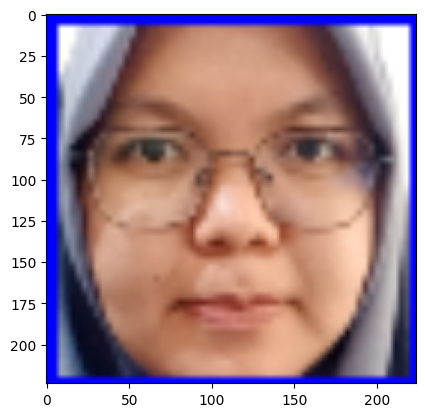

1/1 [==============================] - 0s 20ms/step
Nama File:  2017051016_face_2017051016_20221228_Pulang_27.png
Prediksi 101:  unknown
Probabilitas 101:  0.12521067261695862
Prediksi 50:  unknown
Probabilitas 50:  0.14207348227500916




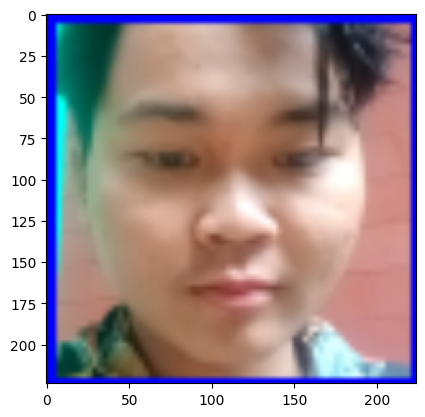

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051004_face_2017051004_20221229_Masuk_16.png
Prediksi 101:  unknown
Probabilitas 101:  0.1304183006286621
Prediksi 50:  unknown
Probabilitas 50:  0.25118038058280945




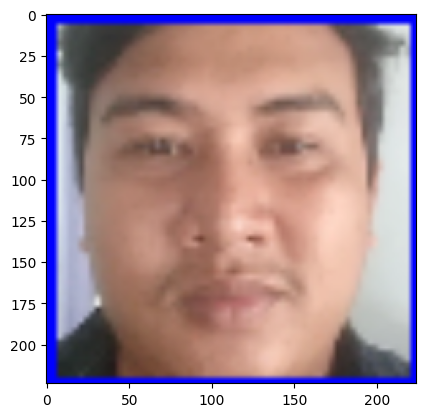

1/1 [==============================] - 0s 21ms/step
Nama File:  1917051029_face_1917051029_20221228_Pulang Cepat_0.png
Prediksi 101:  unknown
Probabilitas 101:  0.13885311782360077
Prediksi 50:  unknown
Probabilitas 50:  0.16581933200359344




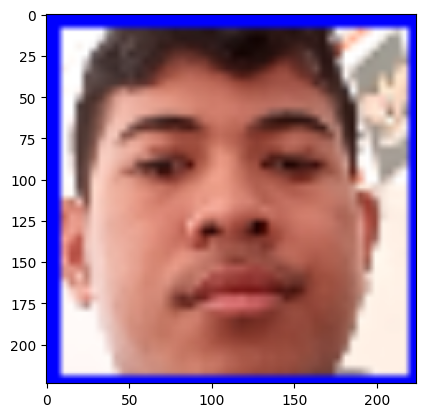

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051081_face_2017051081_20221230_Masuk_26.png
Prediksi 101:  unknown
Probabilitas 101:  0.14641669392585754
Prediksi 50:  unknown
Probabilitas 50:  0.1775364726781845




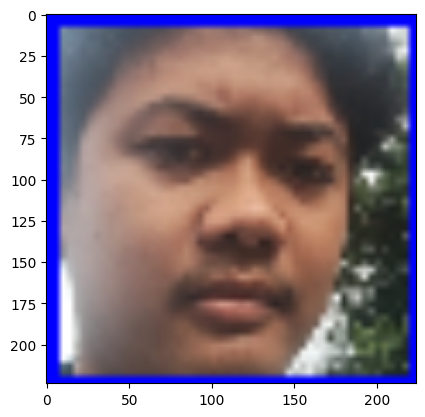

1/1 [==============================] - 0s 21ms/step
Nama File:  2057051003_face_2057051003_20221226_Pulang Cepat_34.png
Prediksi 101:  unknown
Probabilitas 101:  0.15191011130809784
Prediksi 50:  unknown
Probabilitas 50:  0.1726650893688202




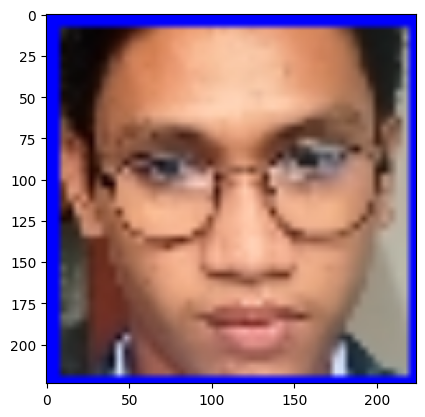

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051014_face_2017051014_20221226_Pulang_8.png
Prediksi 101:  unknown
Probabilitas 101:  0.11517150700092316
Prediksi 50:  unknown
Probabilitas 50:  0.13489355146884918




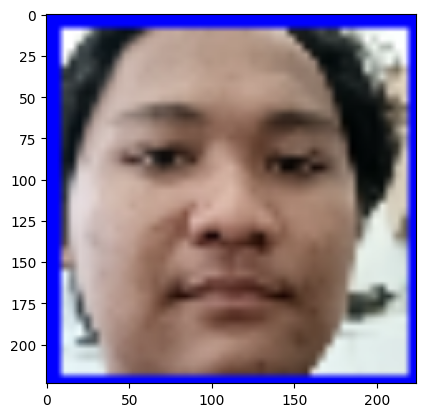

1/1 [==============================] - 0s 21ms/step
Nama File:  1917051047_face_1917051047_20221229_Pulang Cepat_47.png
Prediksi 101:  unknown
Probabilitas 101:  0.13031059503555298
Prediksi 50:  unknown
Probabilitas 50:  0.1624041199684143




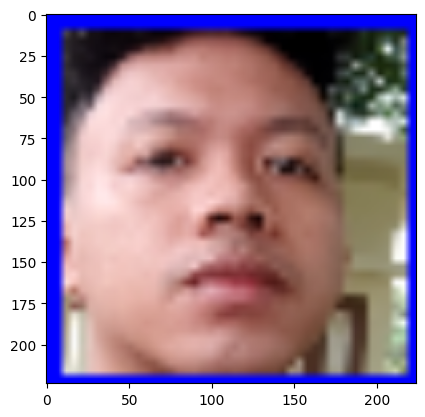

1/1 [==============================] - 0s 20ms/step
Nama File:  2017051020_face_2017051020_20221229_Masuk_31.png
Prediksi 101:  unknown
Probabilitas 101:  0.1801837980747223
Prediksi 50:  unknown
Probabilitas 50:  0.13458216190338135




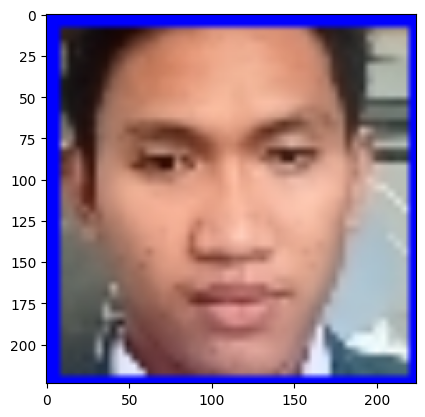

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051014_face_2017051014_20221226_Pulang_58.png
Prediksi 101:  unknown
Probabilitas 101:  0.1261296421289444
Prediksi 50:  unknown
Probabilitas 50:  0.12708362936973572




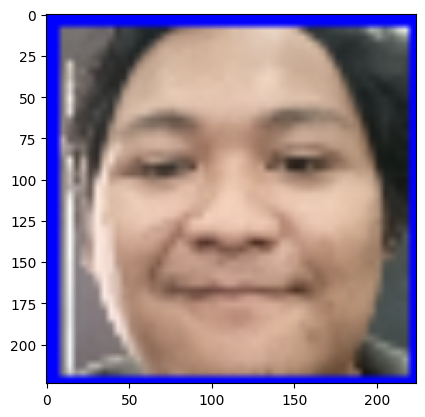

1/1 [==============================] - 0s 21ms/step
Nama File:  1917051047_face_1917051047_20221228_Pulang Cepat_54.png
Prediksi 101:  unknown
Probabilitas 101:  0.14012645184993744
Prediksi 50:  unknown
Probabilitas 50:  0.13242366909980774




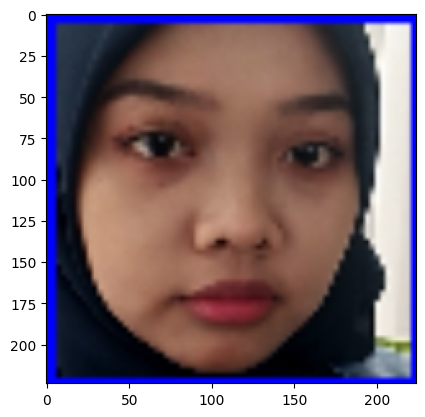

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051079_face_2017051079_20221230_Masuk_48.png
Prediksi 101:  unknown
Probabilitas 101:  0.2805037796497345
Prediksi 50:  unknown
Probabilitas 50:  0.16019144654273987




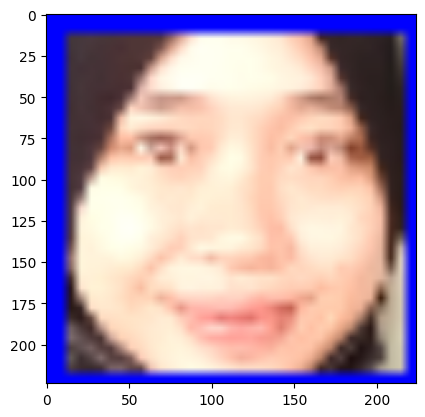

1/1 [==============================] - 0s 21ms/step
Nama File:  2017051031_face_2017051031_20221229_Masuk_37.png
Prediksi 101:  unknown
Probabilitas 101:  0.12113936245441437
Prediksi 50:  2017051031
Probabilitas 50:  0.33650290966033936




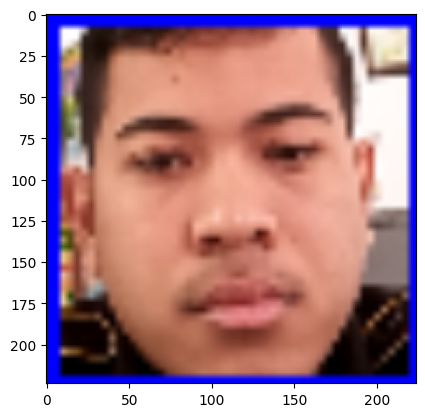

1/1 [==============================] - 0s 24ms/step
Nama File:  2017051081_face_2017051081_20221229_Datang Terlambat_2.png
Prediksi 101:  unknown
Probabilitas 101:  0.15270759165287018
Prediksi 50:  unknown
Probabilitas 50:  0.15870819985866547




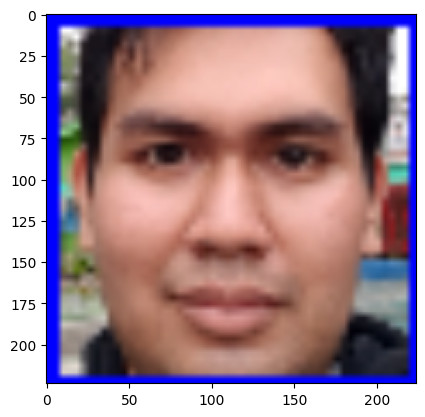

1/1 [==============================] - 0s 21ms/step
Nama File:  2057051016_face_2057051016_20221227_Pulang_64.png
Prediksi 101:  unknown
Probabilitas 101:  0.12744198739528656
Prediksi 50:  unknown
Probabilitas 50:  0.141154482960701


Jumlah prediksi benar 101:  1
Jumlah prediksi benar 50:  2


In [10]:
labels = train_gen.class_names
count_true_50 = 0
count_false_50 = 0
count_true_101 = 0
count_false_101 = 0
for image in os.listdir(testing_path):
  fact = image.split('_')[0]
  
  image_path = os.path.join(testing_path, image)

  img = load_img(image_path, target_size=(224,224))


  # tf.keras.applications.resnetS.preprocess_input(img)


  plt.imshow(img)
  plt.show()

  X = img_to_array(img)
  
  X = np.expand_dims(X, axis=0)

  images = np.vstack([X])

  predict_resnet101 = resnet101.predict(images)
  predict_resnet50 = resnet50.predict(images)

  predicted_class_resnet101 = np.argmax(predict_resnet101, axis=1)[0]
  predicted_class_resnet50 = np.argmax(predict_resnet50, axis=1)[0]
  
  confidential101 = max(predict_resnet101.tolist()[0])
  confidential50 = max(predict_resnet50.tolist()[0])

  if(confidential101 <= 0.3):
    predictions_resnet101 = 'unknown'
  else:
    predictions_resnet101 = labels[predicted_class_resnet101]
        
  if(confidential50 <= 0.3):
    predictions_resnet50 = 'unknown'
  else:
    predictions_resnet50 = labels[predicted_class_resnet50]
    
  if predictions_resnet101 == fact :
    count_true_101 += 1
  else:
    count_false_101 += 1
    
  if predictions_resnet50 == fact :
    count_true_50 += 1
  else:
    count_false_50 += 1
    
  print('Nama File: ', image)
  print('Prediksi 101: ', predictions_resnet101)
  print('Probabilitas 101: ', confidential101)
  print('Prediksi 50: ', predictions_resnet50)
  print('Probabilitas 50: ', confidential50)
  
  print('\n')
print("Jumlah prediksi benar 101: ", count_true_101)
print("Jumlah prediksi benar 50: ", count_true_50)